# Phần 1: import thư viện

In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt 
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU detected:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.10.1
Built with CUDA: True
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all, 1 = info, 2 = warning, 3 = error

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Phần 2: Khám phá dữ liệu

In [5]:
train_dir = "D:/Plant/New Plant Diseases Dataset(Augmented)/train" 


#load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=8,
    shuffle=True
)


class_names = train_ds.class_names
print("Tổng số lớp: ", len(class_names))
for i, name in enumerate(class_names, start=1):
    print(f"{i:02d}. {name}")

Found 70295 files belonging to 38 classes.
Tổng số lớp:  38
01. Apple___Apple_scab
02. Apple___Black_rot
03. Apple___Cedar_apple_rust
04. Apple___healthy
05. Blueberry___healthy
06. Cherry_(including_sour)___Powdery_mildew
07. Cherry_(including_sour)___healthy
08. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
09. Corn_(maize)___Common_rust_
10. Corn_(maize)___Northern_Leaf_Blight
11. Corn_(maize)___healthy
12. Grape___Black_rot
13. Grape___Esca_(Black_Measles)
14. Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15. Grape___healthy
16. Orange___Haunglongbing_(Citrus_greening)
17. Peach___Bacterial_spot
18. Peach___healthy
19. Pepper,_bell___Bacterial_spot
20. Pepper,_bell___healthy
21. Potato___Early_blight
22. Potato___Late_blight
23. Potato___healthy
24. Raspberry___healthy
25. Soybean___healthy
26. Squash___Powdery_mildew
27. Strawberry___Leaf_scorch
28. Strawberry___healthy
29. Tomato___Bacterial_spot
30. Tomato___Early_blight
31. Tomato___Late_blight
32. Tomato___Leaf_Mold
33. Toma

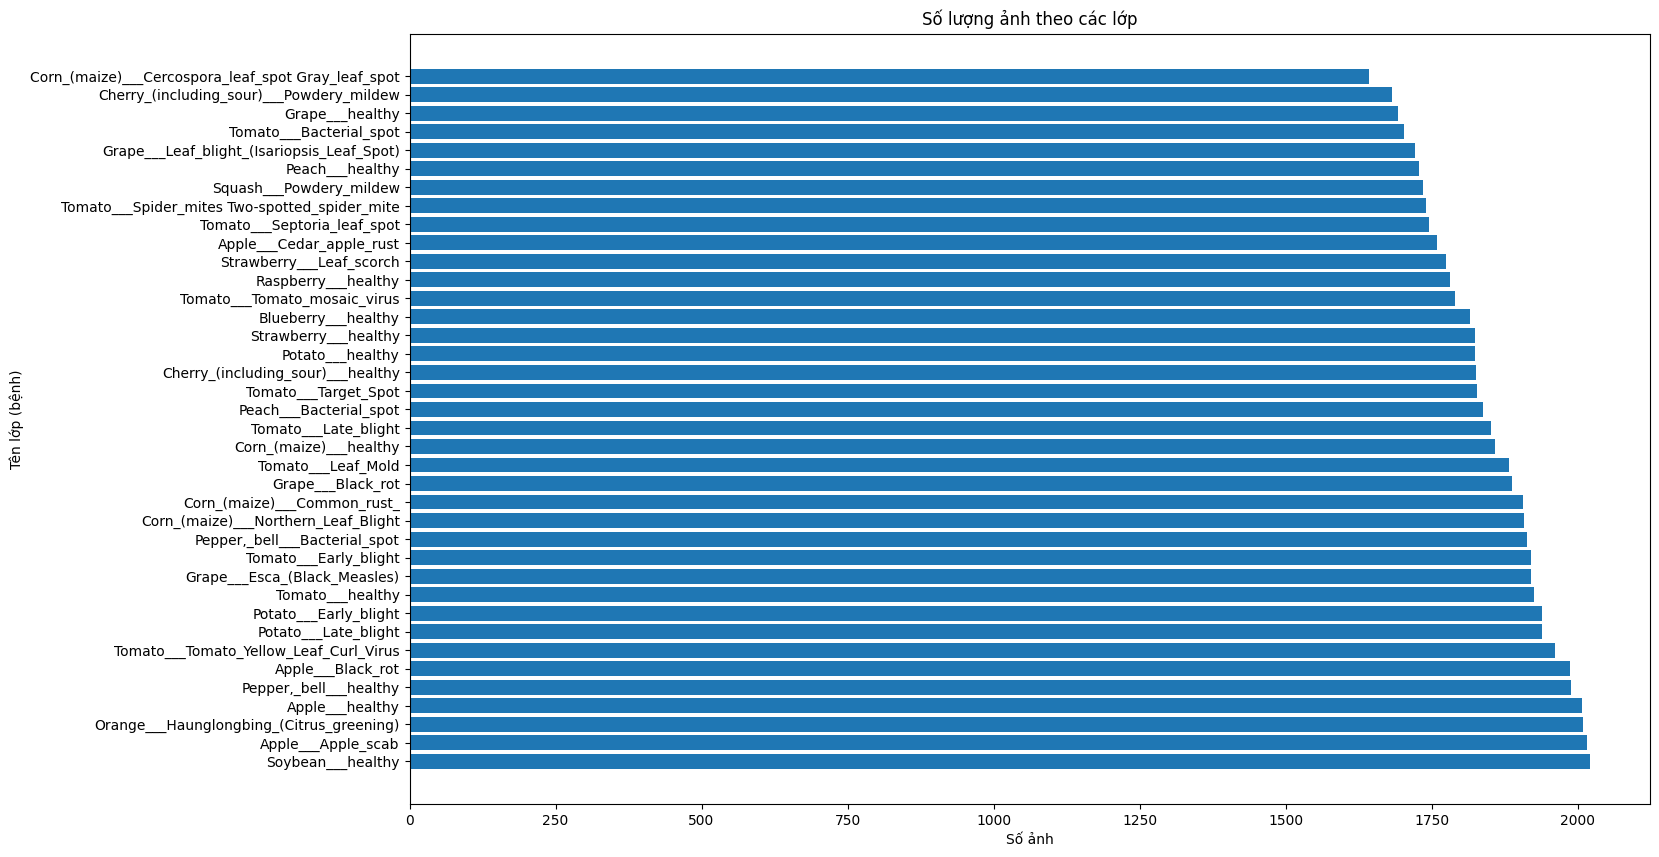

In [6]:
#thống kê ảnh theo từng lớp
counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
df_counts = pd.DataFrame(list(counts.items()), columns=["Class", "Count"]).sort_values(by="Count", ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(df_counts["Class"], df_counts["Count"])
plt.xlabel("Số ảnh")
plt.ylabel("Tên lớp (bệnh)")
plt.title("Số lượng ảnh theo các lớp")
plt.show()

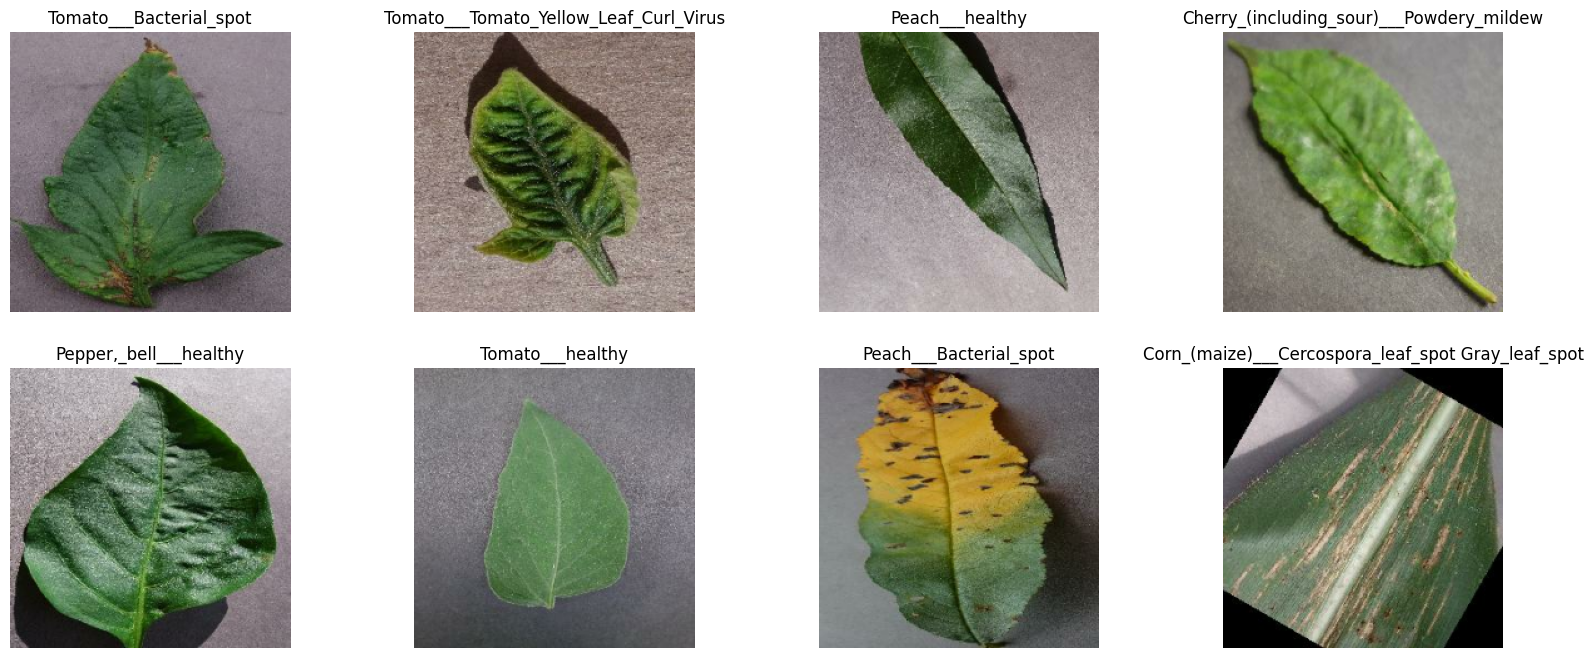

In [7]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(20, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


In [8]:
sample_path = os.path.join(train_dir, class_names[0])
img_path = os.path.join(sample_path, os.listdir(sample_path)[0])

img = PIL.Image.open(img_path)
print("Kích thước ảnh gốc:", img.size)


Kích thước ảnh gốc: (256, 256)


# Phần 3: Tiền xử lý

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


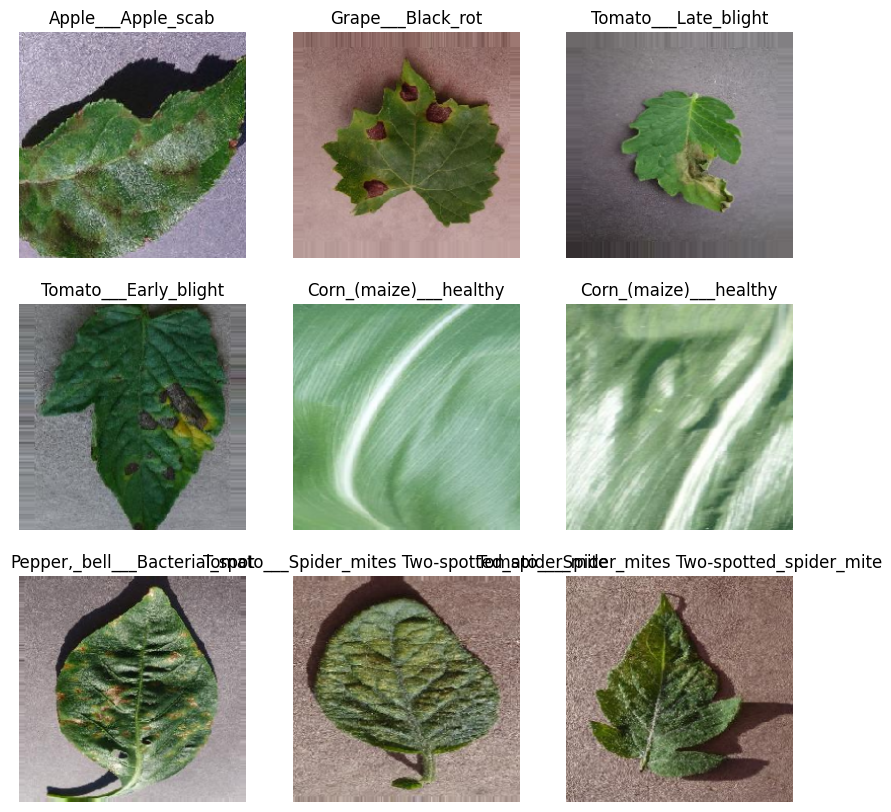

In [7]:
train_dir = "D:/Plant/New Plant Diseases Dataset(Augmented)/train"
val_dir = "D:/Plant/New Plant Diseases Dataset(Augmented)/valid"
test_dir = "D:/Plant/New Plant Diseases Dataset(Augmented)/test"


BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Chuẩn hóa pixel về [0,1]
    # rotation_range=10,         # Xoay nhẹ ±20°
    # width_shift_range=0.2,     # Dịch ngang
    # height_shift_range=0.2,    # Dịch dọc
    zoom_range=0.2,            # Phóng to/thu nhỏ
    horizontal_flip=True       # Lật ngang
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
class_names = list(train_ds.class_indices.keys())

# ảnh sau khi agumentation
x_batch, y_batch = next(train_ds)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(class_names[y_batch[i].argmax()])
    plt.axis("off")
plt.show()



# Phần 4: Khai phá dữ liệu

## Mô hình 1: Machine Learning truyền thống

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
def extract_hog_features(data_dir, img_size=(128,128), limit_per_class = 300):
    X, y =[], []
    for label in os.listdir(data_dir):
        path = os.path.join(data_dir,label)
        if not os.path.isdir(path):
            continue
        files = os.listdir(path)[:limit_per_class]

        for file in tqdm(files, desc =label, disable = True):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, img_size)

            features = hog(
                img, 
                orientations=12,
                pixels_per_cell=(16,16),
                cells_per_block=(3,3),
                block_norm='L2-Hys',
                transform_sqrt=True,
                feature_vector=True
            )

            X.append(features)
            y.append(label)

    return np.array(X, dtype = np.float32), np.array(y)

In [ ]:
X_train, y_train = extract_hog_features(train_dir)
X_val,   y_val   = extract_hog_features(val_dir)

print("Train:", X_train.shape, " Val:", X_val.shape)

In [ ]:
# --- Mã hóa nhãn ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)


# --- Khởi tạo và huấn luyện mô hình ---
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train_enc)

# --- Đánh giá ---
y_pred = svm_model.predict(X_val)
acc = accuracy_score(y_val_enc, y_pred)
f1 = f1_score(y_val_enc, y_pred, average='weighted')

print(f"\nAccuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nBáo cáo chi tiết:\n", classification_report(y_val_enc, y_pred, target_names=le.classes_))



In [ ]:
# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(y_val_enc, y_pred)
plt.figure(figsize=(20, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM với HOG features (Validation set)")
plt.show()

## Mô hình 2:

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)

In [9]:
num_classes = len(class_names)

model = Sequential([

        layers.Input(shape=(224, 224, 3)),
    
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),


        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),


        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),
        

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
])

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    workers = 6,
    use_multiprocessing = False  
)

Epoch 1/50
2197/2197 [==============================] - 299s 132ms/step - loss: 3.6570 - accuracy: 0.0648 - val_loss: 3.4956 - val_accuracy: 0.0588
Epoch 2/50
2197/2197 [==============================] - 272s 124ms/step - loss: 3.4973 - accuracy: 0.0647 - val_loss: 3.4350 - val_accuracy: 0.0573
Epoch 3/50
2197/2197 [==============================] - 273s 124ms/step - loss: 3.4188 - accuracy: 0.0793 - val_loss: 3.3769 - val_accuracy: 0.0796
Epoch 4/50
2197/2197 [==============================] - 272s 124ms/step - loss: 3.3849 - accuracy: 0.0846 - val_loss: 9.0638 - val_accuracy: 0.0588
Epoch 5/50
2197/2197 [==============================] - 273s 124ms/step - loss: 3.3405 - accuracy: 0.0910 - val_loss: 3.1519 - val_accuracy: 0.1122
Epoch 6/50
2197/2197 [==============================] - 272s 123ms/step - loss: 3.3001 - accuracy: 0.0977 - val_loss: 3.1989 - val_accuracy: 0.1287
Epoch 7/50
2197/2197 [==============================] - 269s 122ms/step - loss: 3.2465 - accuracy: 0.1129 - val_

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")